# PREP

In [1]:
import random
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wildlifeml.utils.io import (
    load_csv, 
    load_json, 
    load_pickle,
    load_image,
)
from wildlifeml.utils.datasets import render_bbox
from wildlifeml.preprocessing.cropping import Cropper

2023-03-22 18:48:42.429372: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/lisa-wm/miniconda2/envs/wildlife/lib/python3.10/site-packages/cv2/../../lib64:
2023-03-22 18:48:42.429389: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-22 18:48:43.474252: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/lisa-wm/miniconda2/envs/wildlife/lib/python3.10/site-packages/cv2/../../lib64:
2023-03-22 18:48:43.474265: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-22 18:48:43.474277: I tensorflow/stream_executor/cuda

In [2]:
REPODIR = '/home/wimmerl/projects/wildlife-experiments'
IMGDIR = '/common/bothmannl/wildlife_images/usecase2/original_images/'
CFG = load_json(os.path.join(REPODIR, 'configs/cfg.json'))

FileNotFoundError: [Errno 2] No such file or directory: '/home/wimmerl/projects/wildlife-experiments/configs/cfg.json'

In [265]:
LABEL_MAP = load_json(os.path.join(REPODIR, 'data/label_map.json'))
LABEL_DICT = {k: v for k, v in load_csv(os.path.join(CFG['data_dir'], CFG['label_file']))}
MAPPING_DICT = load_json(os.path.join(CFG['data_dir'], CFG['mapping_file']))
DETECTOR_DICT = load_json(os.path.join(CFG['data_dir'], CFG['detector_file']))
META_DF = pd.read_csv(os.path.join(CFG['data_dir'], 'metadata.csv'))

# DESCRIPTIVE

## STATS

In [266]:
cnt_ins_oos = META_DF.groupby(['station_set', 'true_class'])['orig_name'].count()
cnt_ins_oos, cnt_ins_oos.groupby(['true_class']).sum()  # Table 1

(station_set  true_class   
 s1           empty            15627
              european_hare      485
              others             941
              red_deer            26
              red_fox            708
              red_squirrel       297
              roe_deer          6074
              wild_boar          210
 s2           empty            14274
              european_hare      255
              others            1051
              red_deer           135
              red_fox            106
              red_squirrel        13
              roe_deer          7010
              wild_boar          904
 Name: orig_name, dtype: int64,
 true_class
 empty            29901
 european_hare      740
 others            1992
 red_deer           161
 red_fox            814
 red_squirrel       310
 roe_deer         13084
 wild_boar         1114
 Name: orig_name, dtype: int64)

## EXEMPLARY MISCLASSIFIED CASES

In [255]:
RESULTS_INSAMPLE = load_pickle('results/202302101741_insample_test.pkl')
OUR_THRESH = 0.25

In [258]:
def inspect_images(
    results, 
    label: str, 
    label_map: dict, 
    mapping_dict: dict,
    detector_dict: dict,
    n_displays: int, 
    img_dir: str,
    is_misclassified: bool,
    sorting: str,  # ['asc', 'desc', 'rand'],
    min_conf: float = 0.,
    max_conf: float = 1.
):
    result_ranking = pd.DataFrame(
        zip(
            list(results['preds_imgs'].keys()), 
            [np.argmax(v) for v in results['preds_imgs'].values()],
            [np.max(v) for v in results['preds_imgs'].values()],
            results['truth_imgs'],
        ),
        columns=['img', 'pred_label', 'conf', 'true_label']
    )
    result_ranking = result_ranking.loc[result_ranking['true_label'] == label_map[label]]
    if is_misclassified:
        result_ranking = result_ranking.loc[result_ranking['pred_label'] != label_map[label]]

    if sorting == 'asc':
        img_keys = result_ranking.sort_values('conf')['img'][:n_displays]
    elif sorting == 'desc':
        img_keys = result_ranking.sort_values('conf', ascending=False)['img'][:n_displays]
    else: 
        img_keys = random.sample(list(result_ranking['img']), n_displays)

    for k in img_keys:
        pred_class = np.argmax(results['preds_imgs'][k])
        bbox_keys = mapping_dict[k]
        fig, ax = plt.subplots(figsize=(6, 6))
        img = load_image(os.path.join(img_dir, k))
        width, height = img.size
        x_coords, y_coords = [], []
        for bkey in bbox_keys:
            x, y = Cropper.get_absolute_coords(detector_dict[bkey].get('bbox'), (height, width))
            x_coords.append(x)
            y_coords.append(y)
        img = render_bbox(img, x_coords, y_coords)
        ax.imshow(img)
        plt.show()
        plt.close()
        pred_class_name = [k for k, v in label_map.items() if v == pred_class][0]
        conf = result_ranking.loc[result_ranking['img'] == k]['conf'].item()
        print(
            f'Image: {k}\nTrue: {label}\nPredicted: {pred_class_name}\nConfidence: {conf:.2f}'
        )


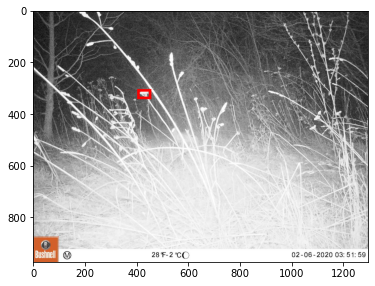

Image: 32977_02060651.JPG
True: european_hare
Predicted: empty
Confidence: 1.00


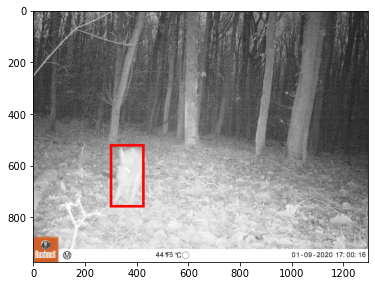

Image: 18619_01090949.JPG
True: european_hare
Predicted: red_fox
Confidence: 0.87


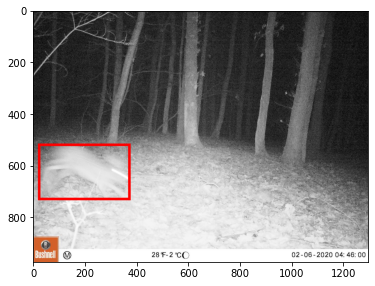

Image: 18871_02060202.JPG
True: european_hare
Predicted: red_fox
Confidence: 0.74


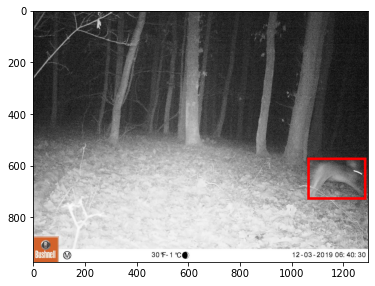

Image: 18220_12030550.JPG
True: european_hare
Predicted: roe_deer
Confidence: 0.61


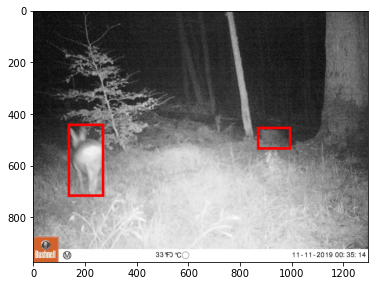

Image: 11872_11110200.JPG
True: european_hare
Predicted: roe_deer
Confidence: 0.59


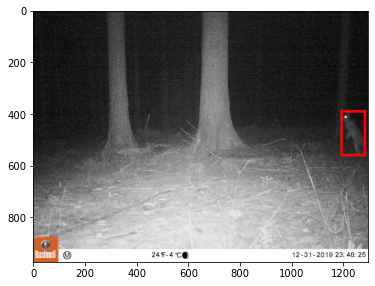

Image: 6473_12310281.JPG
True: european_hare
Predicted: roe_deer
Confidence: 0.58


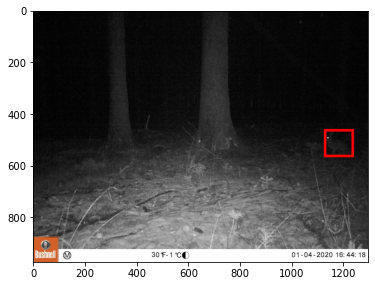

Image: 3850_01040756.JPG
True: european_hare
Predicted: roe_deer
Confidence: 0.57


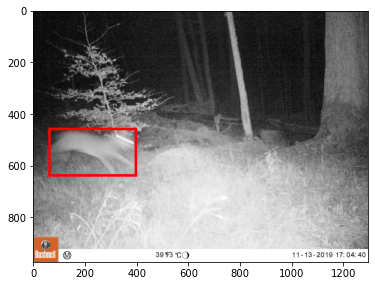

Image: 11686_11130220.JPG
True: european_hare
Predicted: roe_deer
Confidence: 0.57


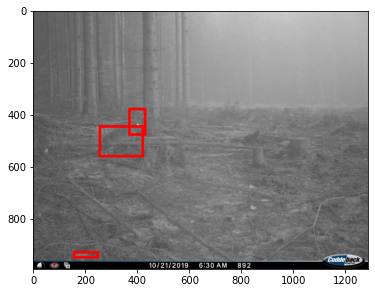

Image: 11157_I_00064a.JPG
True: european_hare
Predicted: roe_deer
Confidence: 0.54


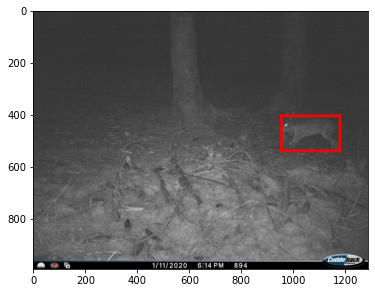

Image: 20497_I_00314a.JPG
True: european_hare
Predicted: roe_deer
Confidence: 0.53


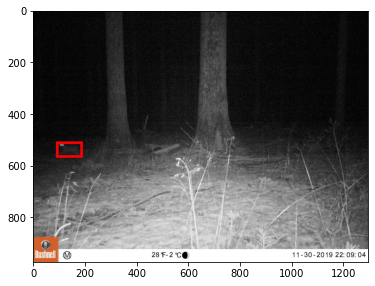

Image: 5715_11300973.JPG
True: european_hare
Predicted: empty
Confidence: 0.50


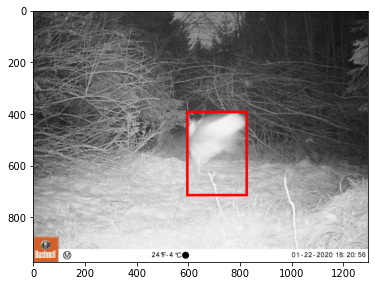

Image: 127294_01220157.JPG
True: european_hare
Predicted: others
Confidence: 0.49


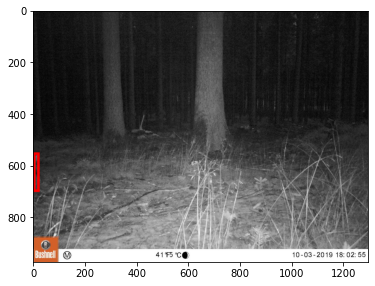

Image: 8205_10030523.JPG
True: european_hare
Predicted: roe_deer
Confidence: 0.49


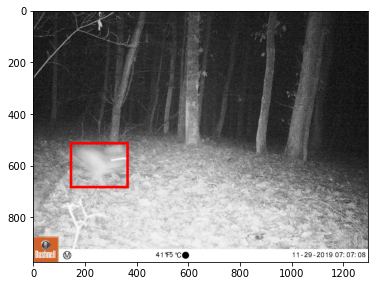

Image: 18157_11290487.JPG
True: european_hare
Predicted: red_fox
Confidence: 0.48


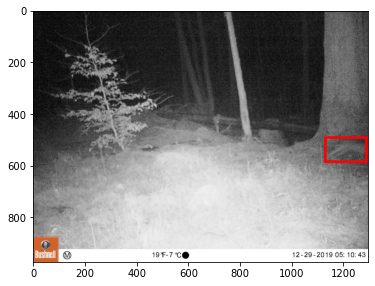

Image: 11955_12290325.JPG
True: european_hare
Predicted: others
Confidence: 0.47


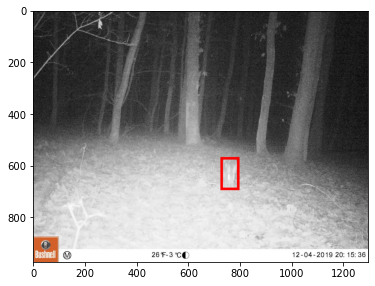

Image: 18235_12040565.JPG
True: european_hare
Predicted: red_fox
Confidence: 0.40


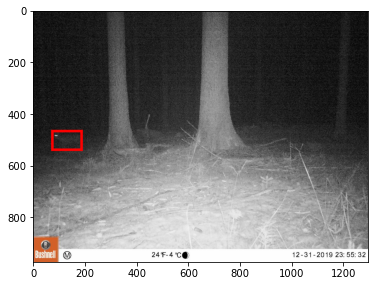

Image: 6712_12310285.JPG
True: european_hare
Predicted: roe_deer
Confidence: 0.39


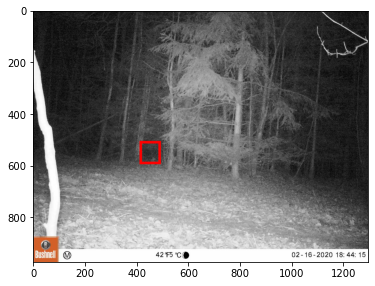

Image: 48333_02160087.JPG
True: european_hare
Predicted: empty
Confidence: 0.39


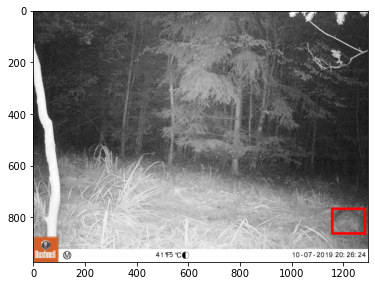

Image: 48358_10070251.JPG
True: european_hare
Predicted: others
Confidence: 0.38


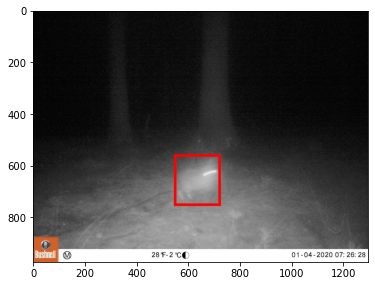

Image: 5835_01040721.JPG
True: european_hare
Predicted: roe_deer
Confidence: 0.38


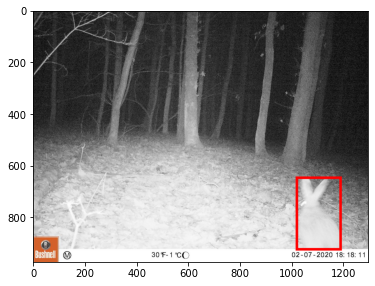

Image: 18943_02070274.JPG
True: european_hare
Predicted: red_fox
Confidence: 0.37


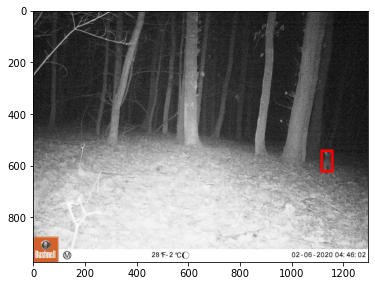

Image: 18873_02060204.JPG
True: european_hare
Predicted: empty
Confidence: 0.35


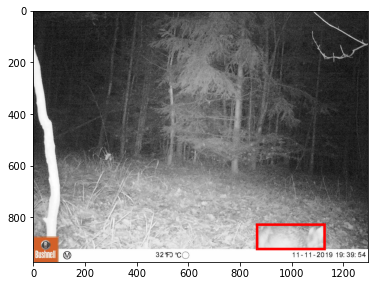

Image: 49696_11110071.JPG
True: european_hare
Predicted: others
Confidence: 0.26


In [259]:
inspect_images(
    results=results, 
    label='european_hare',
    label_map=LABEL_MAP,
    mapping_dict=MAPPING_DICT,
    detector_dict=DETECTOR_DICT,
    n_displays=100,
    img_dir=IMGDIR,
    is_misclassified=True,
    sorting='desc'
)

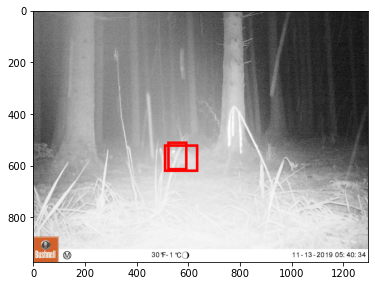

Image: 55015_11130511.JPG
True: european_hare
Predicted: european_hare
Confidence: 0.61


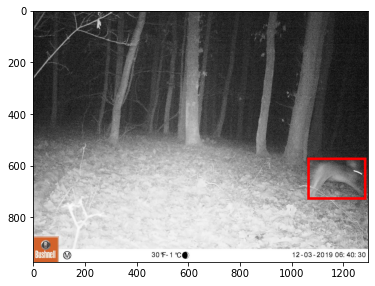

Image: 18220_12030550.JPG
True: european_hare
Predicted: roe_deer
Confidence: 0.61


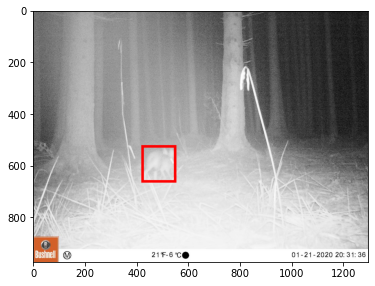

Image: 109445_01210996.JPG
True: european_hare
Predicted: european_hare
Confidence: 0.98


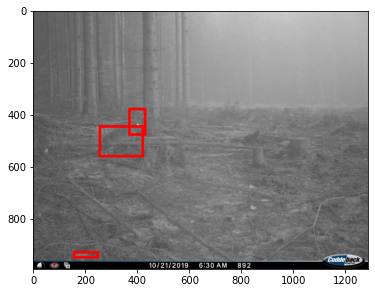

Image: 11157_I_00064a.JPG
True: european_hare
Predicted: roe_deer
Confidence: 0.54


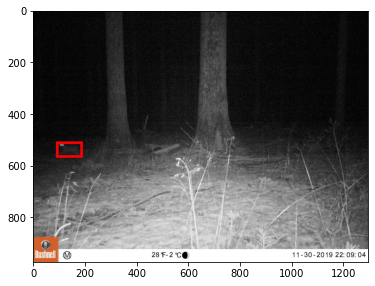

Image: 5715_11300973.JPG
True: european_hare
Predicted: empty
Confidence: 0.50


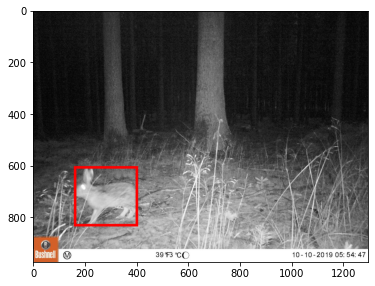

Image: 3532_10100860.JPG
True: european_hare
Predicted: european_hare
Confidence: 0.94


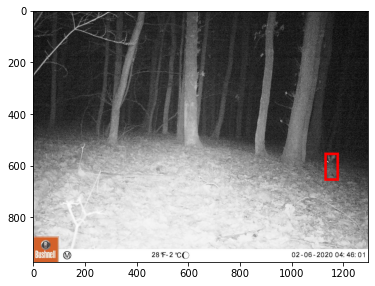

Image: 18872_02060203.JPG
True: european_hare
Predicted: european_hare
Confidence: 0.70


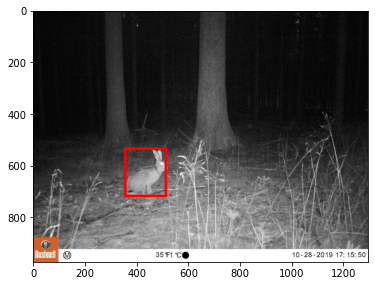

Image: 3775_10280630.JPG
True: european_hare
Predicted: european_hare
Confidence: 0.95


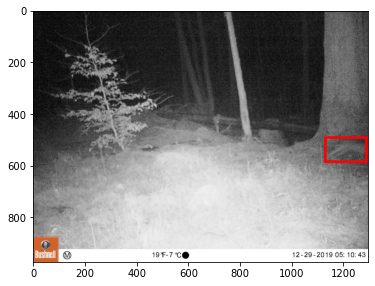

Image: 11955_12290325.JPG
True: european_hare
Predicted: others
Confidence: 0.47


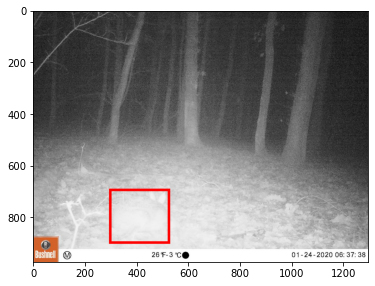

Image: 18771_01240102.JPG
True: european_hare
Predicted: european_hare
Confidence: 0.98


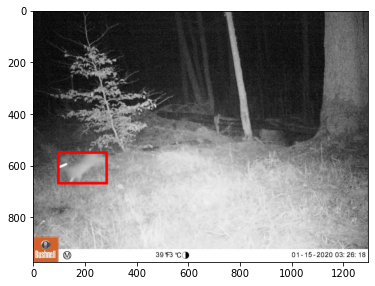

Image: 11836_01150393.JPG
True: european_hare
Predicted: european_hare
Confidence: 0.71


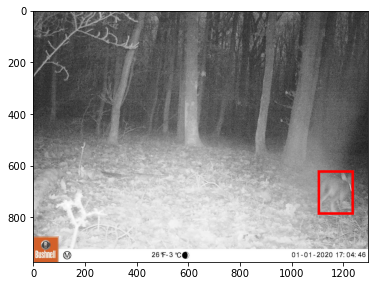

Image: 18506_01010836.JPG
True: european_hare
Predicted: european_hare
Confidence: 0.41


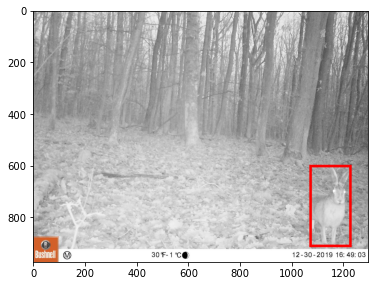

Image: 18488_12300818.JPG
True: european_hare
Predicted: european_hare
Confidence: 0.44


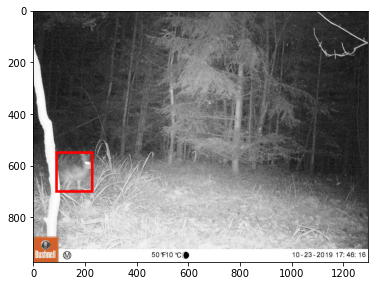

Image: 49188_10230661.JPG
True: european_hare
Predicted: european_hare
Confidence: 0.95


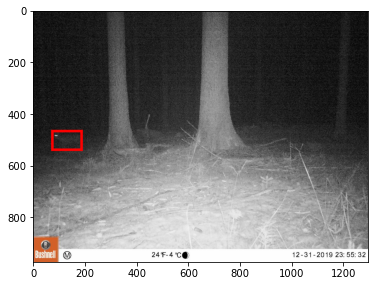

Image: 6712_12310285.JPG
True: european_hare
Predicted: roe_deer
Confidence: 0.39


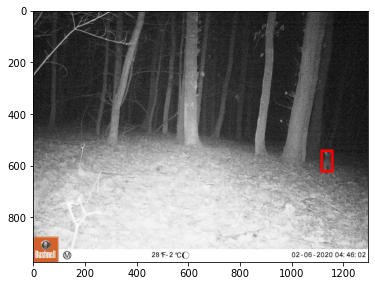

Image: 18873_02060204.JPG
True: european_hare
Predicted: empty
Confidence: 0.35


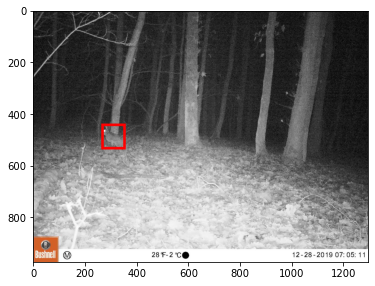

Image: 18458_12280788.JPG
True: european_hare
Predicted: european_hare
Confidence: 0.89


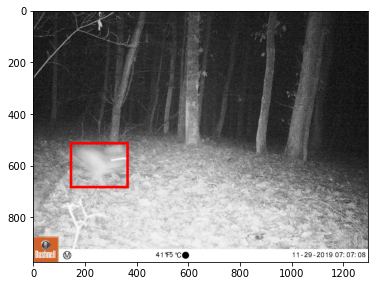

Image: 18157_11290487.JPG
True: european_hare
Predicted: red_fox
Confidence: 0.48


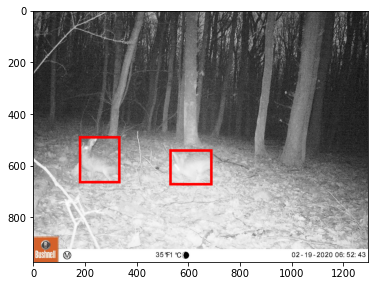

Image: 19065_02190396.JPG
True: european_hare
Predicted: european_hare
Confidence: 0.78


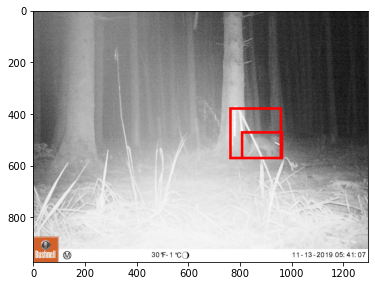

Image: 108961_11130512.JPG
True: european_hare
Predicted: european_hare
Confidence: 0.81


In [262]:
inspect_images(
    results=results, 
    label='european_hare',
    label_map=LABEL_MAP,
    mapping_dict=MAPPING_DICT,
    detector_dict=DETECTOR_DICT,
    n_displays=20,
    img_dir=IMGDIR,
    is_misclassified=False,
    sorting='rand',
    min_conf=0.8,
)